# Практическое задание №7 по теме "Линейная регрессия. Двухвыборочный t-тест. A/B-тестирование".

В поле ответа впишите одно число. Нецелые числа следует округлить до 8 знаков после запятой.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_formats = ['svg']

## Задание 1

Дана матрица объект-признак
```
X = [[ 1.22401313,  2.30868478,  3.03636353,  2.69287214],
     [-0.18757272,  1.30337355,  5.12093014,  3.46363202],
     [-0.81094525,  1.82463398,  5.79686488,  1.86159445],
     [ 0.75129018,  2.67392052,  3.65529809,  1.66746094],
     [ 0.00972362,  1.97367255,  2.50594319,  1.69755173],
     [-0.62972637,  0.77750764,  2.84124027,  4.54410559],
     [ 2.29536229,  1.81206697,  1.95026215,  1.51874636],
     [ 0.0920418 ,  2.26971361,  7.47708735,  2.61081203],
     [ 2.39252799,  3.17563985,  3.61420599,  5.10773362],
     [ 0.54983815,  2.87988651,  1.65752765,  1.59635987]]
```
и значения целевой переменной
```
y = [ 9.26193358,  9.700363  ,  8.67214805,  8.74796974,  6.18689108,
      7.53312713,  7.57643777, 12.44965478, 14.29010746,  6.68361218]
```

Подберите два признака (из четырёх) так, чтобы уровень линейной зависимости целевой переменной от значений этих признаков был максимальным. Другими словами, модель линейной регрессии на этих признаках должна давать наилучший результат. В качестве ответа запишите значение коэффициента детерминации для модели на этих признаках.

___Решение___

In [2]:
def calculate_r2(b, x, y: pd.Series) -> float:
    """Расчет коэффициента детерминации R.
    """
    z = x.dot(b)
    e = y - z
    e_sq = ((e - e.mean()) ** 2).sum()
    y_sq = ((y - y.mean()) ** 2).sum()
    R2 = 1 - e_sq/y_sq
    return R2

In [3]:
# j - объект (10), i - признак (4)
X = pd.DataFrame([[ 1.22401313,  2.30868478,  3.03636353,  2.69287214],
                  [-0.18757272,  1.30337355,  5.12093014,  3.46363202],
                  [-0.81094525,  1.82463398,  5.79686488,  1.86159445],
                  [ 0.75129018,  2.67392052,  3.65529809,  1.66746094],
                  [ 0.00972362,  1.97367255,  2.50594319,  1.69755173],
                  [-0.62972637,  0.77750764,  2.84124027,  4.54410559],
                  [ 2.29536229,  1.81206697,  1.95026215,  1.51874636],
                  [ 0.0920418 ,  2.26971361,  7.47708735,  2.61081203],
                  [ 2.39252799,  3.17563985,  3.61420599,  5.10773362],
                  [ 0.54983815,  2.87988651,  1.65752765,  1.59635987]])
n_features = X.shape[1]
n_objects = X.shape[0]

In [4]:
y = pd.Series([9.26193358,  9.700363  ,  8.67214805,  8.74796974,  6.18689108,
      7.53312713,  7.57643777, 12.44965478, 14.29010746,  6.68361218])

In [5]:
result = {'R':0, 'Features':(), 'b':[]}
f_combinations = combinations(range(n_features), r=2)
for comb in f_combinations:
    x_train = pd.DataFrame(np.ones((n_objects, 1)))
    x_train = pd.concat([x_train ,X[[comb[0], comb[1]]]], axis=1, ignore_index=True)
    y_train = y
    lr = LinearRegression(fit_intercept=False).fit(x_train, y_train)
    b = lr.coef_
    R = calculate_r2(b, x_train, y_train)   
    if  R > result['R']:
        result['R'] = R
        result['Features'] = comb
        result['b'] = b

print(f"Индексы признаков: {result['Features']}, b: {b}, Коэффициент детерминации R2: {round(result['R'], 8)}")

Индексы признаков: (0, 2), b: [3.64001086 0.70753914 1.04851745], Коэффициент детерминации R2: 0.76342462


___Ответ:___ $R^2$ = 0.76342462

---

## Задание 2

Является ли значимым уравнение регрессии, полученное в предыдущей задаче? В качестве ответа запишите 1, если является, и 0 иначе.

___Решение___

1. В качестве нулевой гипотезы $H_{0}$ берется гипотеза о том, что коэффициент детерминации $R^{2}$ равен `0`

2. Для определения коэффициента детерминации мы проводим F-тест, соответственно при данном тесте используется __F-статистика__:

$$F = \dfrac{R^2 / m}{(1 - R^2) / (n - m - 1)},$$
где $R^2$ — коэффициент детерминации, $n$ — число наблюдений, $m$ — число факторов (признаков).

3. Возьмем уровень значимости $\alpha = 0.05$

4. Критическая область $\Omega_\alpha$

Выбранная статистика имеет имеет __F-распределение Фишера__ с параметрами $k_1 = m$, $k_2 = n - m - 1$. Распределение Фишера имеет один хвост, поэтому рассматривается правосторонняя критическая область $\Omega_\alpha = \left( t_{1 - \alpha, \: k_1, k_2}, \infty \right)$, где $t_{1 - \alpha, \: k_1, k_2}$ — квантиль порядка $1 - \alpha$ для распределения Фишера с параметрами $k_1$, $k_2$. 

In [6]:
R2 = 0.76342462
alpha = 0.05
# в 1 задании строилась модель на основе 2 признаков
m = 2
n = X.shape[0]
k1 = m
k2 = n-m-1

Найдём квантиль с помощью `scipy.stats.f.ppf`.

In [7]:
t = stats.f.ppf(1-alpha, k1, k2)
t

4.73741412777588

Итак, критическая область:
$$\Omega_\alpha = (4.73741412777588, \infty)$$

Изобразим

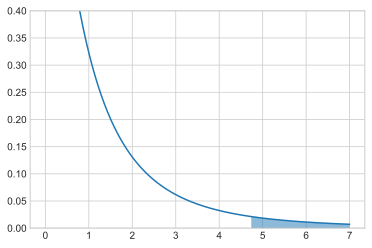

In [8]:
ox = np.linspace(0, 7, 500)
oy = stats.f.pdf(ox, k1, k2)

ox_right = np.linspace(t, 7, 100)
oy_right = stats.f.pdf(ox_right, k1, k2)

plt.plot(ox, oy)
plt.fill_between(ox_right, oy_right, alpha=0.5)
plt.ylim(0, 0.4)
plt.show()

5. Статистический тест

In [9]:
S = R2*k2/k1/(1-R2)
S

11.29443888032643

Найденное значение статистики попало в критическую область $\Omega_\alpha = (4.73741412777588, \infty)$. Соответственно нулевую гипотезу нужно отвергнуть, уравнение регрессии признать значимым.

Для большей уверенности найдем __P-значение__. Для правосторонней области $\Omega_\alpha = \left( t_{1 - \alpha}, \infty \right)$ имеем условие $t_{1 - \alpha} = S$, откуда $$P_r = 1 - F_S(S)$$

In [10]:
p_right = 1 - stats.f.cdf(S, k1, k2)
p_right

0.006440111881158006

Мы получили P-значение $<0.01$,что говорит нам о том, что только при очень маленьком (близком к 0) уровне значимости от нулевой гипотезы можно не отказываться. 
Так как выбранная $\alpha = 0.05 > P_{value}$, то нулевую гипотезу $H_{0}$ опять же отвергаем и считаем уравнение регрессии значимым. 

___Ответ:___ 1

---

## Задание 3

Для проведения A/B-тестирования сайта интернет-магазина были получены следующие данные: страница `A` была посещена 2509 раз, из них 77 закончились совершением покупки, страница `B` была посещена 1465 раз, 60 из них закончились совершением покупки. Является ли значимым отличие конверсии на страницах `A` и `B`? В качестве ответа запишите 1, если является, и 0 иначе.

_Подсказка_. Реализуйте двухвыборочный t-тест. В качестве выборок здесь можно взять наборы меток совершения покупки (0 или 1) каждым посетителем.

___Решение___

Среднее квадратическое отклонение разности между выборочными средними выборок $X_1$ и $X_2$:

$$\sigma_\Delta = \sqrt{\dfrac{\sigma_{X_1}^2}{n_1} + \dfrac{\sigma_{X_2}^2}{n_2}},$$

где $\sigma_{X_i}^2$ — несмещённая оценка дисперсии по выборке $X_i$, а $n_1$ и $n_2$ - размеры выборок.

1. Пусть нулевая гипотеза $H_{0}$ - конверсии на страницах `A` и `B` равны, а альтернативная гипотеза $H_1$ - конверсии на страницах `A` и `B` не равны.

2. Статистика: 

$$t = \dfrac{\overline{X_1} - \overline{X_2}}{\sigma_\Delta}$$

3. Уровень значимости $\alpha = 0.05$

4. Критическая область $\Omega_\alpha$

В предположении нулевой гипотезы данная статистика имеет распределение Стьюдента. Число степеней свободы распределения определяется из следующего равенства:
$$df = \dfrac{\left( \dfrac{\sigma_{X_1}^2}{n_1} + \dfrac{\sigma_{X_2}^2}{n_2} \right)^2}{\dfrac{\left( \sigma_{X_1}^2 / n_1 \right)^2}{n_1 - 1} + \dfrac{\left( \sigma_{X_2}^2 / n_2 \right)^2}{n_2 - 1}}$$

Критическая область является двухсторонней (строится с использованием квантилей $t_{x, \: df}$ распределения Стьюдента)

Зададим выборку и расчитаем необходимые значения перед статистическим тестом:

In [11]:
A = np.append(np.zeros((2509 - 77)), np.ones((77)))
B = np.append(np.zeros((1465 - 60)), np.ones((60)))

A, B

(array([0., 0., 0., ..., 1., 1., 1.]), array([0., 0., 0., ..., 1., 1., 1.]))

Посчитаем значение $\sigma_\Delta$:

In [12]:
n_a = A.size
n_b = B.size

std_a = A.std(ddof=1)
std_b = B.std(ddof=1)

In [13]:
std_delta = np.sqrt(std_a ** 2 / n_a + std_b ** 2 / n_b)
std_delta

0.006220171278295827

Зададим $\alpha$:

In [14]:
alpha = 0.05

Найдем число степеней свободы:

In [15]:
df_ = (std_a ** 2 / n_a + std_b ** 2 / n_b) ** 2 / ((std_a ** 2 / n_a)**2 / (n_a - 1) + (std_b ** 2 / n_b)**2 / (n_b - 1))
df_

2732.8025644352133

Определим критическую область $\Omega_\alpha$:

In [16]:
t1 = stats.t.ppf(alpha / 2, df=df_)
t2 = stats.t.ppf(1 - alpha / 2, df=df_)

t1, t2

(-1.9608324352746576, 1.9608324352746571)

Итак, критическая область:
$$\Omega_\alpha = (- \infty, -1.9608324352746576) \cup (1.9608324352746571, \infty)$$

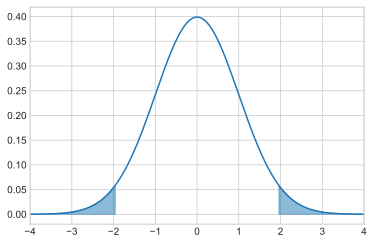

In [17]:
ox = np.linspace(-4, 4, 1000)
oy = stats.t.pdf(ox, df=df_)

ox_left = np.linspace(-5, t1, 500)
oy_left = stats.t.pdf(ox_left, df=df_)

ox_right = np.linspace(t2, 5, 500)
oy_right = stats.t.pdf(ox_right, df=df_)

plt.plot(ox,oy)
plt.fill_between(ox_left, oy_left, alpha=0.5, color='C0')
plt.fill_between(ox_right, oy_right, alpha=0.5, color='C0')
plt.xlim([-4,4])
plt.show()

5. Статистический тест

In [18]:
S = (A.mean() - B.mean()) / std_delta
S

-1.6504551408398205

In [19]:
stats.ttest_ind(A, B, equal_var=False)

Ttest_indResult(statistic=-1.6504551408398205, pvalue=0.09896479217925898)

Значение статистики не попало в критическую область, а также $P_{value} > \alpha$. Значит гипотеза $H_{0}$ принимается, а гипотеза $H_{1}$ отвергается.

Вопрос задачи звучит так: "Является ли значимым отличие конверсии на страницах A и B? В качестве ответа запишите 1, если является, и 0 иначе"

Так как мы принимаем $H_{0}$, значит принимаем равенство конверсий, а отличие отвергаем. Поэтому отличие конверсии на страницах A и B не является значимым. 

___Ответ:___ 0

---